# Data preperation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import torch.nn.functional as F
import pathlib


cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Hyper-parameters 
num_epochs = 75
batch_size = 4
learning_rate = 0.001

In [3]:
train_transform = transforms.Compose([
        transforms.Resize(126),
        transforms.RandomResizedCrop(124),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
   
val_transform =transforms.Compose([
        transforms.Resize(126),
        transforms.CenterCrop(124),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [4]:

train_path = 'data/dog/train'
test_path = 'data/dog/test'

trainset = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(test_path, transform=val_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Get class names
root=pathlib.Path(train_path)
classNames=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classNames)

['dog', 'notDog']


In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

dataiter = iter(trainloader)
images, labels = next(dataiter)

out = torchvision.utils.make_grid(images)

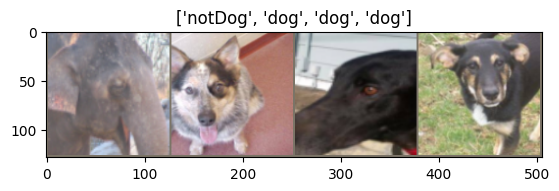

In [8]:
imshow(out, title=[classNames[x] for x in labels])

# Train the model

In [9]:
# get shape for first linear layer
conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)
x = conv1(images)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)

torch.Size([4, 6, 120, 120])
torch.Size([4, 6, 60, 60])
torch.Size([4, 16, 56, 56])
torch.Size([4, 16, 28, 28])


In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 28 * 28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classNames))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net().to(device)

In [11]:
# weight the loss function to bias a positive result
weight = torch.tensor([0.55, 0.45], dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weight.to(device))

optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
train_losses, val_losses = [], []
for epoch in range(num_epochs):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(trainloader.dataset)
    train_losses.append(train_loss)

    #Validation phase
    net.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            # Move inputs and labels to the device
            inputs, labels = data[0].to(device), data[1].to(device)
         
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(testloader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


print('Finished Training')

Epoch 1/75 - Train loss: 0.6486869028009352, Validation loss: 0.6027426327000737
Epoch 2/75 - Train loss: 0.6147749156030711, Validation loss: 0.5660464284849949
Epoch 3/75 - Train loss: 0.5980108326515083, Validation loss: 0.5472582951362575
Epoch 4/75 - Train loss: 0.5799514184803535, Validation loss: 0.5451675412386865
Epoch 5/75 - Train loss: 0.5687865563986039, Validation loss: 0.5427820613568505
Epoch 6/75 - Train loss: 0.5638073091745075, Validation loss: 0.4913279971975912
Epoch 7/75 - Train loss: 0.5603975335804945, Validation loss: 0.5295774355216663
Epoch 8/75 - Train loss: 0.5617824204342369, Validation loss: 0.5169821982989545
Epoch 9/75 - Train loss: 0.5474838090257038, Validation loss: 0.5031685430774644
Epoch 10/75 - Train loss: 0.540889573757674, Validation loss: 0.4831336722859733
Epoch 11/75 - Train loss: 0.535182153617704, Validation loss: 0.45935462488502754
Epoch 12/75 - Train loss: 0.5277383636789099, Validation loss: 0.4693065660061267
Epoch 13/75 - Train loss: 

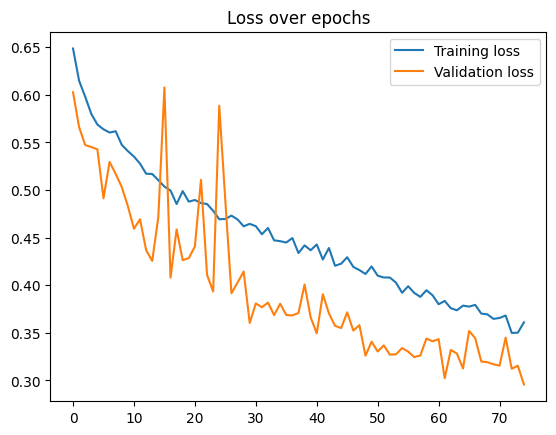

[0.6486869028009352, 0.6147749156030711, 0.5980108326515083, 0.5799514184803535, 0.5687865563986039, 0.5638073091745075, 0.5603975335804945, 0.5617824204342369, 0.5474838090257038, 0.540889573757674, 0.535182153617704, 0.5277383636789099, 0.5171268347013382, 0.5169174268836599, 0.5102849004543935, 0.503644646064498, 0.4995215235426105, 0.48528082501869757, 0.4988672342775071, 0.48783043967183803, 0.48954950537763603, 0.4863514252621674, 0.4852984445222076, 0.4781966737064637, 0.4693169771910002, 0.4696490990861474, 0.4731429085279482, 0.4691565658949884, 0.46193572838545643, 0.46449777674941084, 0.46204232973111004, 0.4536051967463845, 0.46016377509934775, 0.44719672126337817, 0.4462902991313536, 0.44488508139414723, 0.44959421773995045, 0.4338172172180028, 0.44190992093815956, 0.4367681689339236, 0.44285631086452276, 0.42703291198821464, 0.43914011643819933, 0.42050467180706474, 0.4226479294187245, 0.4294529536944952, 0.41926854438398226, 0.4159320141477595, 0.41183081594621673, 0.419

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()
print(train_losses)
print(val_losses)

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 87 %


Training function for transfer learning

In [15]:
def train_model(model, scheduler):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in trainloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len(trainset)
                epoch_acc = running_corrects.double() / len(trainset)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                    
                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [16]:
model_fit = train_model(net,  exp_lr_scheduler)

Epoch 0/74
----------
train Loss: 0.3623 Acc: 0.8423
val Loss: 0.3539 Acc: 0.8467

Epoch 1/74
----------
train Loss: 0.3604 Acc: 0.8431
val Loss: 0.3433 Acc: 0.8548

Epoch 2/74
----------
train Loss: 0.3462 Acc: 0.8525
val Loss: 0.3555 Acc: 0.8362

Epoch 3/74
----------
train Loss: 0.3594 Acc: 0.8450
val Loss: 0.3388 Acc: 0.8516

Epoch 4/74
----------
train Loss: 0.3451 Acc: 0.8520
val Loss: 0.3460 Acc: 0.8563

Epoch 5/74
----------
train Loss: 0.3575 Acc: 0.8462
val Loss: 0.3668 Acc: 0.8401

Epoch 6/74
----------
train Loss: 0.3419 Acc: 0.8540
val Loss: 0.3603 Acc: 0.8521

Epoch 7/74
----------
train Loss: 0.3179 Acc: 0.8645
val Loss: 0.3142 Acc: 0.8678

Epoch 8/74
----------
train Loss: 0.3080 Acc: 0.8737
val Loss: 0.3061 Acc: 0.8694

Epoch 9/74
----------
train Loss: 0.3132 Acc: 0.8701
val Loss: 0.3062 Acc: 0.8712

Epoch 10/74
----------
train Loss: 0.3078 Acc: 0.8725
val Loss: 0.3003 Acc: 0.8758

Epoch 11/74
----------
train Loss: 0.3031 Acc: 0.8726
val Loss: 0.3004 Acc: 0.8741

Ep

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model_fit(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 89 %


In [19]:
torch.save(model_fit.state_dict(), 'dogModelState.pt')

In [20]:
torch.save(model_fit, 'dogModel.pt')

# Transfer learning and fine tuning

In [74]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(classNames))

model_ft = model_ft.to(device)

In [ ]:
model_ft = train_model(model_ft, exp_lr_scheduler)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [77]:
# freeze all network layers except the final layer
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

In [ ]:
model_ft = train_model(model_ft, exp_lr_scheduler)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

# Display results

In [21]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classNames[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

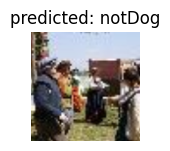

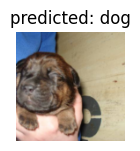

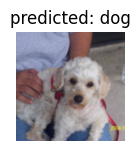

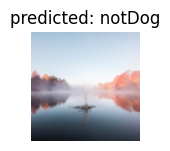

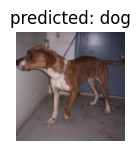

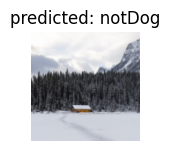

In [26]:
visualize_model(model_fit)

In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classNames}
total_pred = {classname: 0 for classname in classNames}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_fit(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classNames[label]] += 1
            total_pred[classNames[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: dog   is 90.2 %
Accuracy for class: notDog is 88.6 %


In [27]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = val_transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {classNames[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

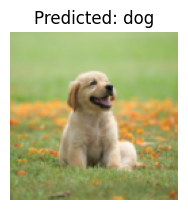

In [28]:
visualize_model_predictions(
    model_fit,
    img_path='data/dogVal/dog6.jpg'
)

plt.ioff()
plt.show()

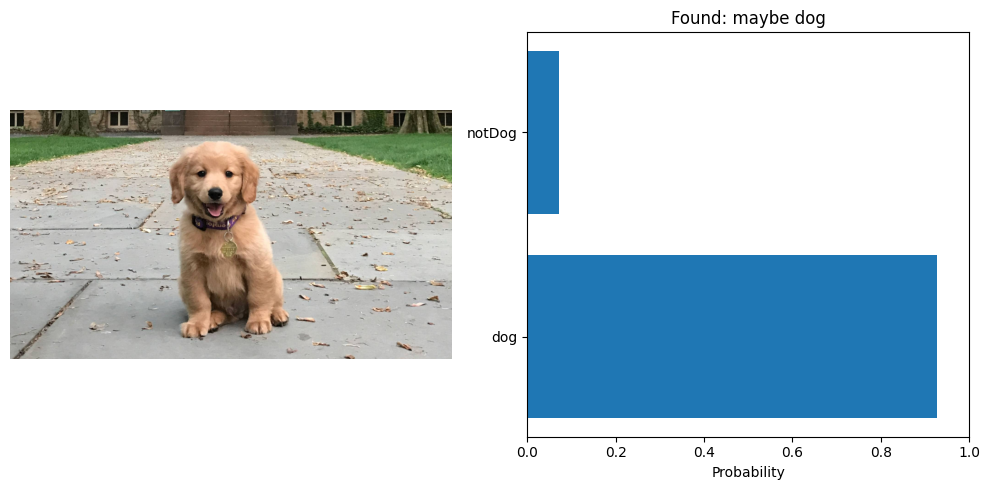

In [29]:
# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image, val_transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    found_classes = []
    for i, x in enumerate(classNames):
        if(probabilities[i] > 0.95):
            found_classes.append(x)
            
        elif(probabilities[i] > 0.5):
            found_classes.append('maybe ' + x )
    if(found_classes == []):
        found_classes.append('none')

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Found: " + ', '.join(found_classes))
    axarr[1].set_xlim(0, 1)

 

    plt.tight_layout()
    plt.show()

test_image = "data/dog/val/dog1.jpg"


original_image, image_tensor = preprocess_image(test_image)
probabilities = predict(model_fit, image_tensor, device)


visualize_predictions(original_image, probabilities, classNames)

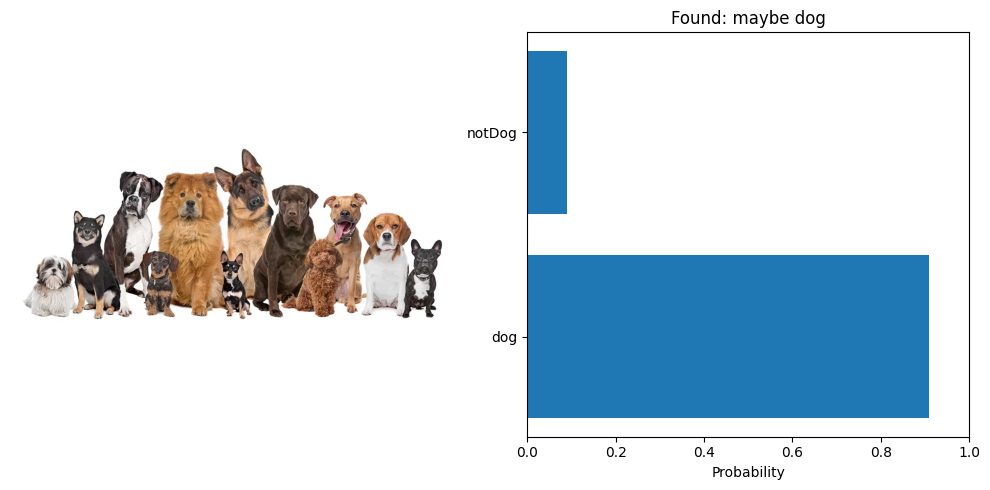

In [30]:
test_image = "data/dog/val/dog2.webp"


original_image, image_tensor = preprocess_image(test_image)
probabilities = predict(model_fit, image_tensor, device)


visualize_predictions(original_image, probabilities, classNames)

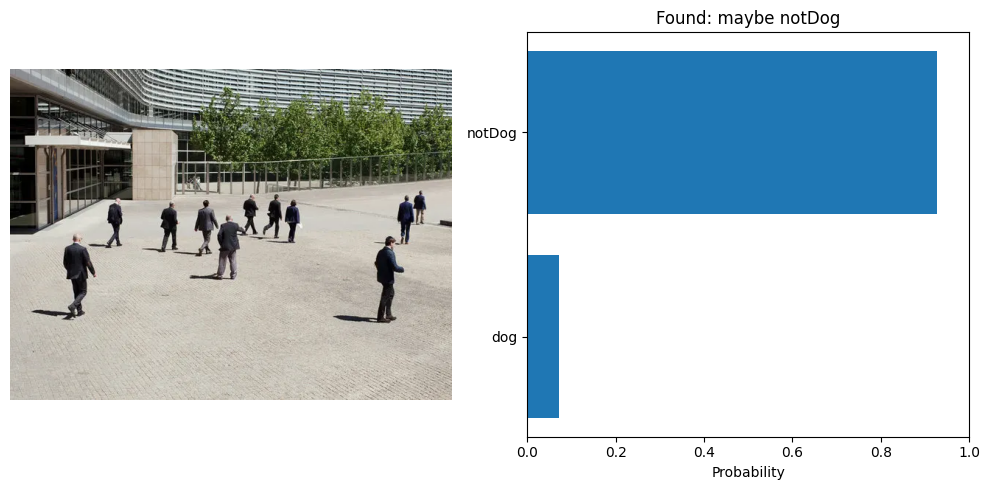

In [31]:
test_image = "data/ValViolence/Other/13cameras10-articleLarge.webp"


original_image, image_tensor = preprocess_image(test_image)
probabilities = predict(model_fit, image_tensor, device)


visualize_predictions(original_image, probabilities, classNames)

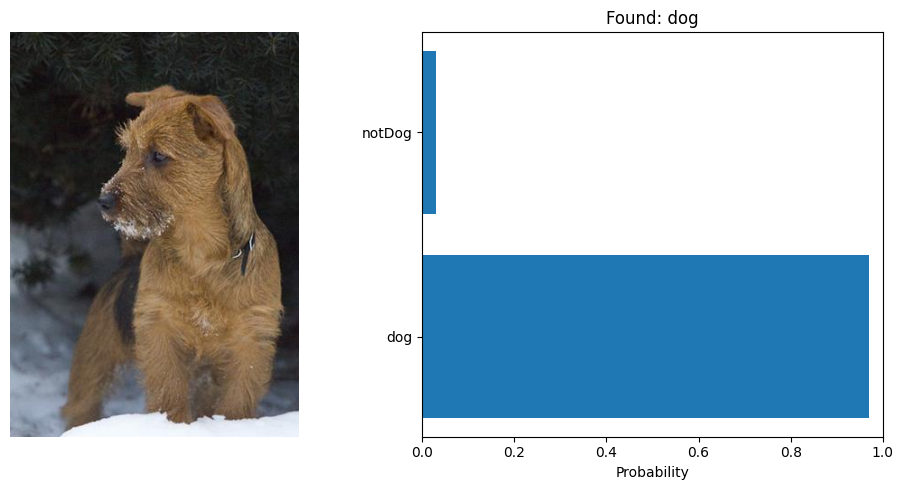

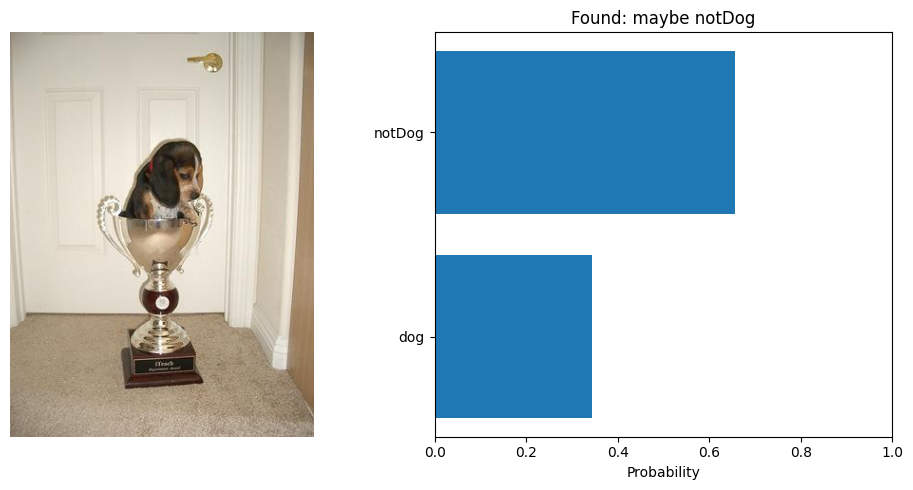

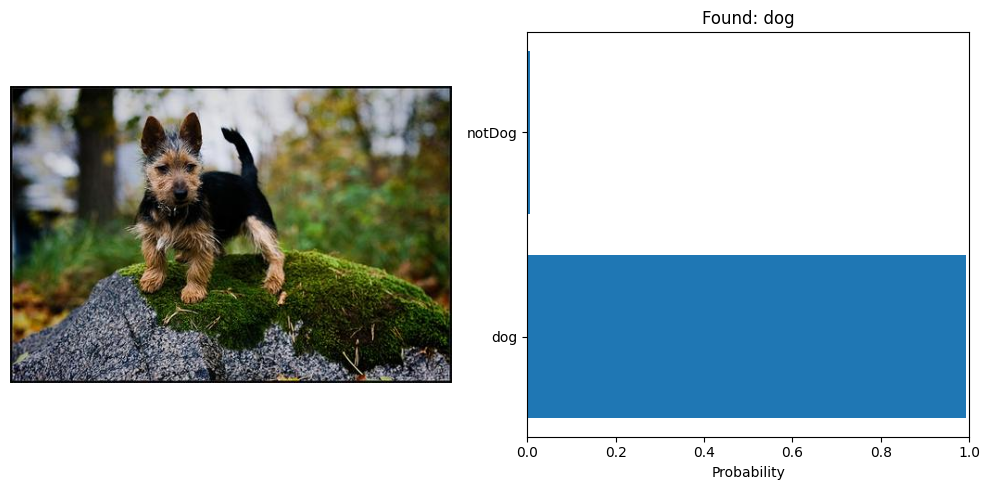

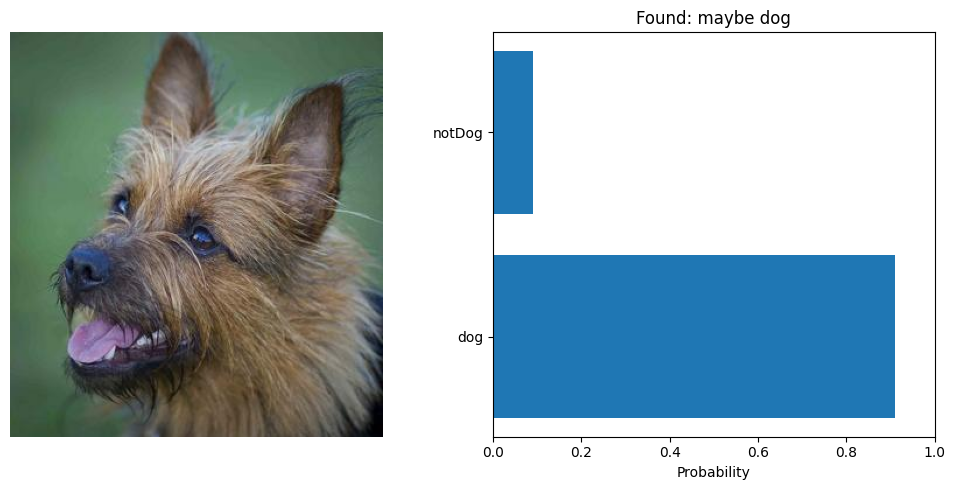

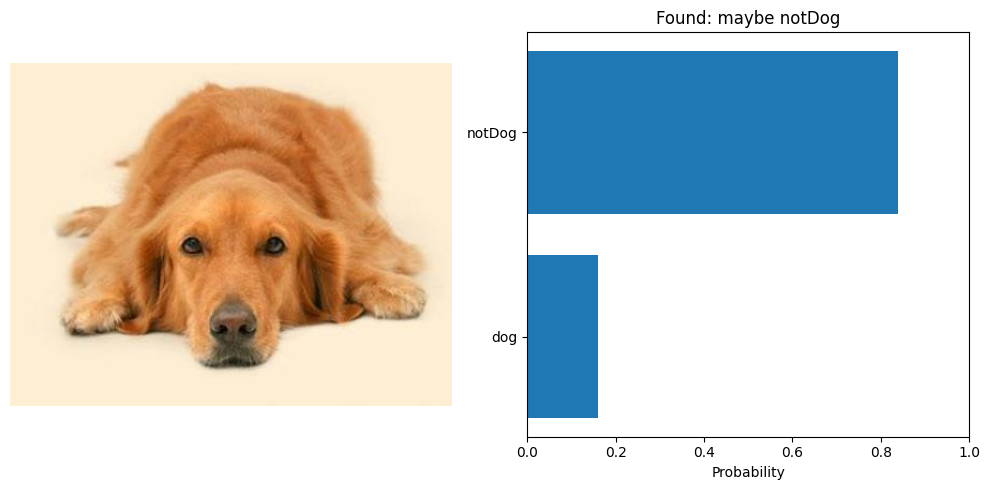

In [32]:
from glob import glob
test_images = glob('data/dog/val/*')
test_examples = np.random.choice(test_images, 5)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example)
    probabilities = predict(model_fit, image_tensor, device)
 
    visualize_predictions(original_image, probabilities, classNames)

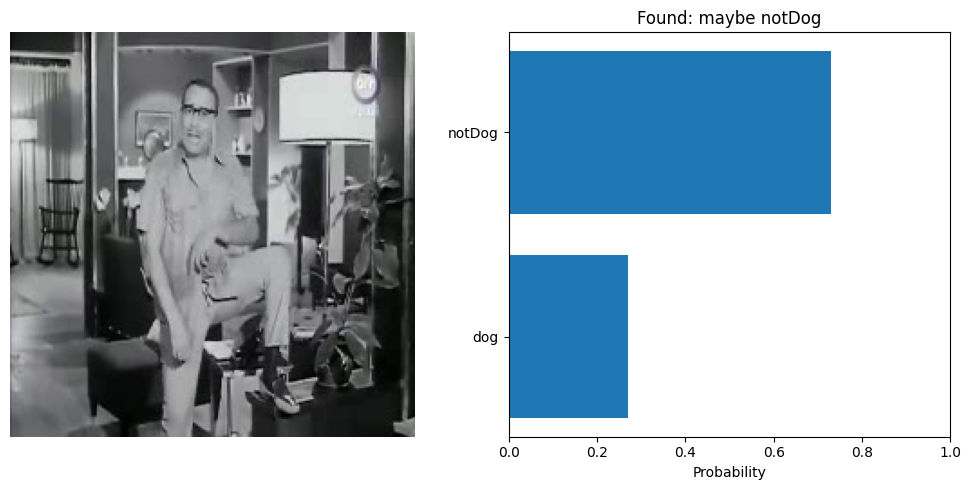

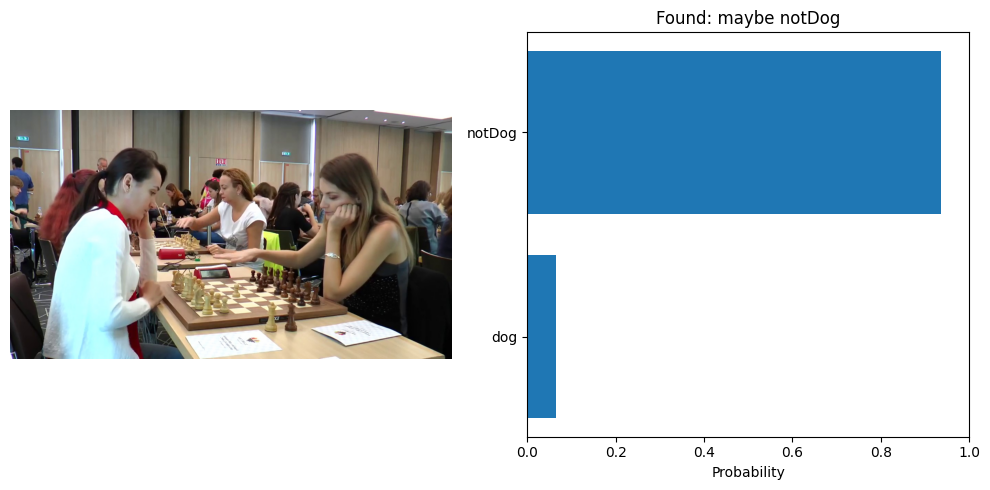

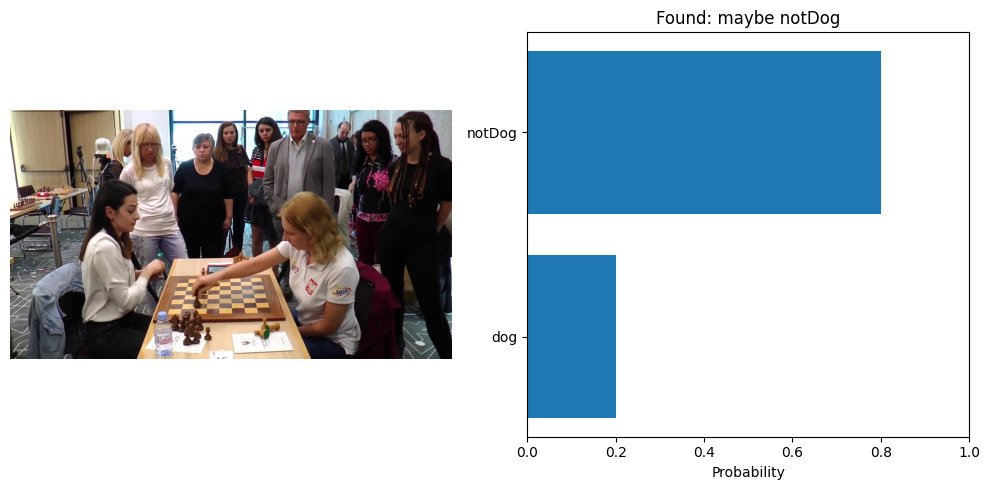

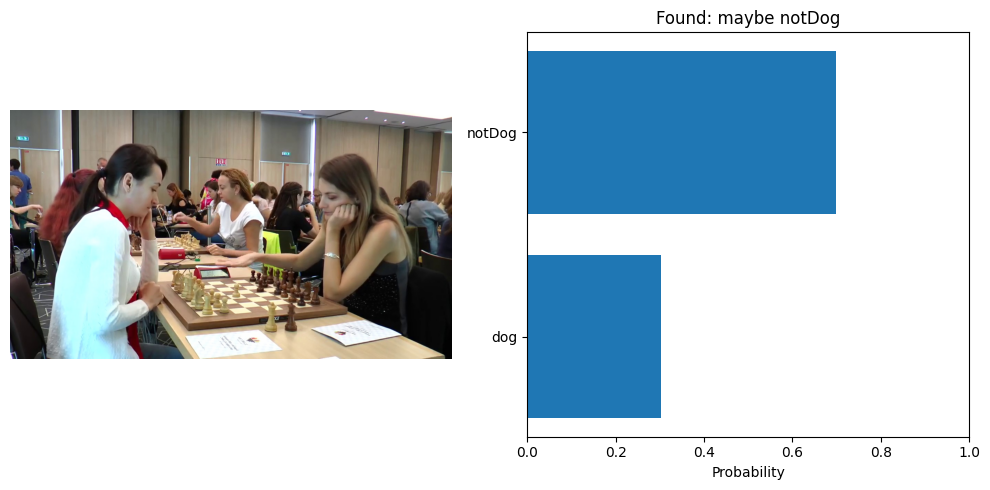

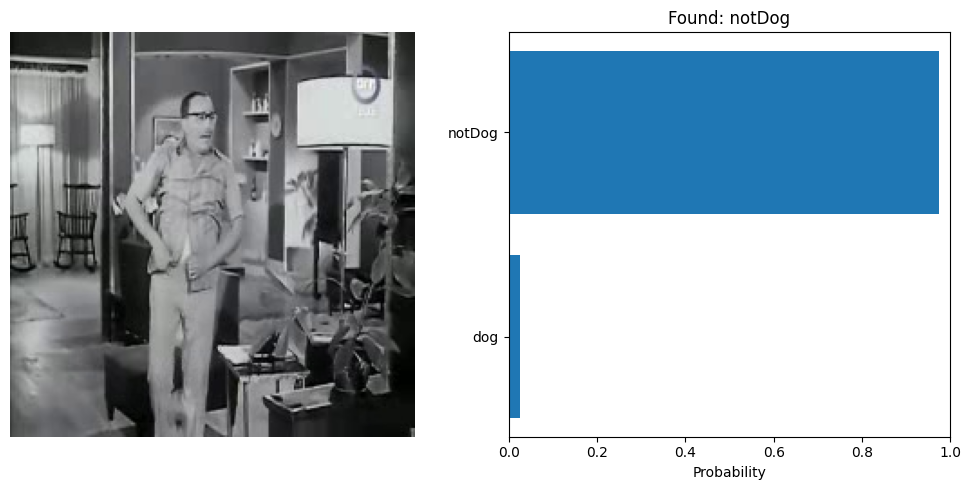

In [33]:
from glob import glob
test_images = glob('data/ValViolence/NonViolence/*/**')
test_examples = np.random.choice(test_images, 5)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example)
    probabilities = predict(model_fit, image_tensor, device)
 
    visualize_predictions(original_image, probabilities, classNames)

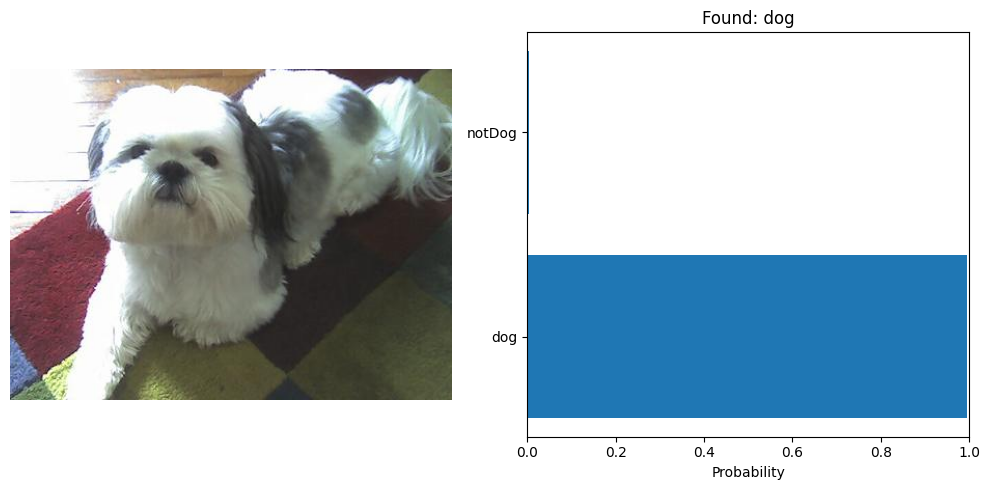

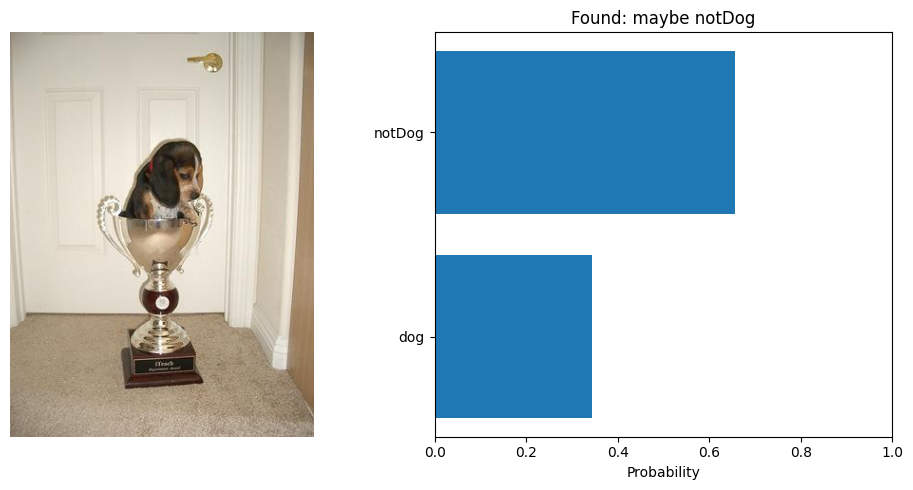

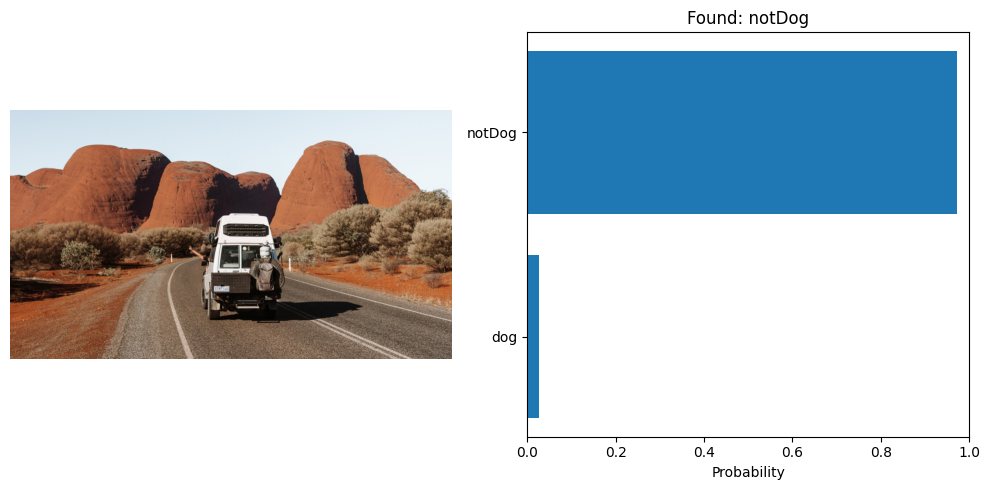

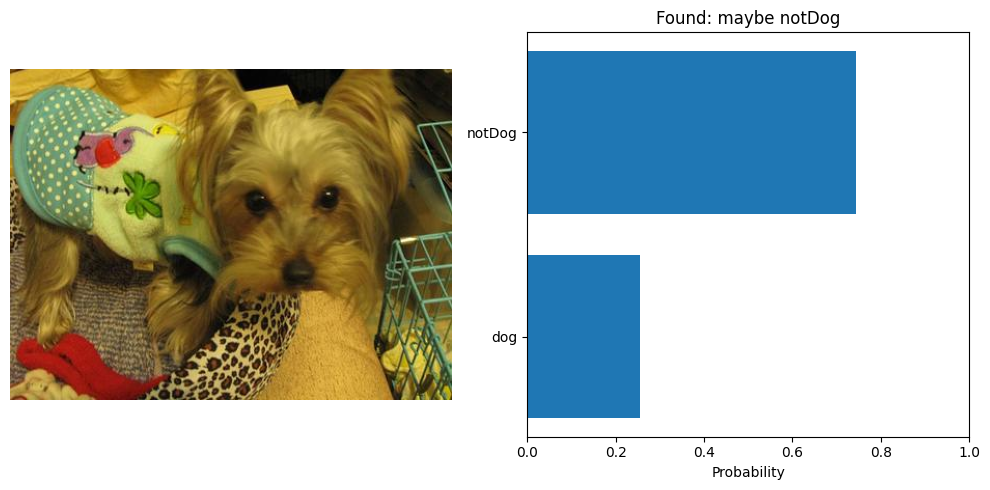

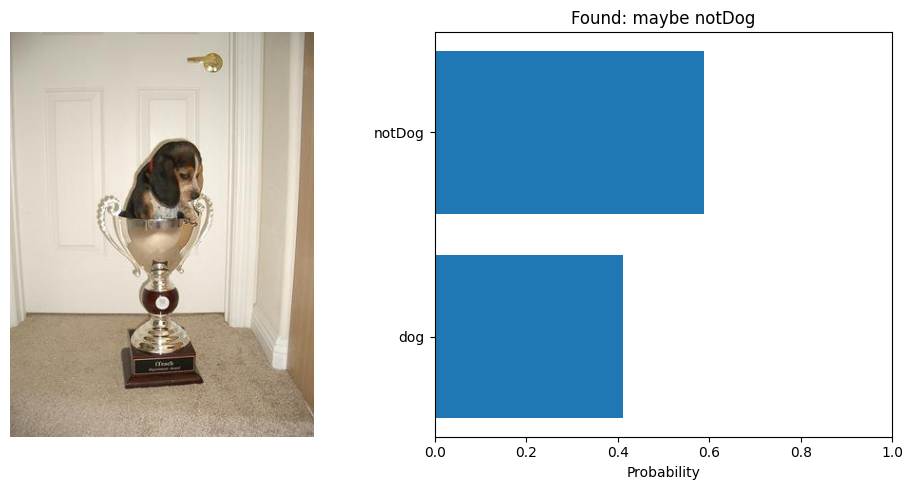

In [34]:
from glob import glob
test_images = glob('data/dog/val/*')
test_examples = np.random.choice(test_images, 5)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example)
    probabilities = predict(model_fit, image_tensor, device)
 
    visualize_predictions(original_image, probabilities, classNames)

# Extract frames from videos

In [49]:
import cv2
import os
import glob
from tqdm import tqdm

In [42]:
PATH_video = "Data/videos"

In [57]:
os.makedirs('./data/frames',exist_ok=True)
for path in tqdm(glob.glob(PATH_video+'/*')):
    fname = os.path.basename(path).split('.')[0]
    vidcap = cv2.VideoCapture(path)
    success,image = vidcap.read()
    count = 0
    while success:
        if count % 5 == 0:
            cv2.imwrite("./data/frames/{}-{}.jpg".format(fname,str(count).zfill(4)),image)     # save frame as JPEG file      
        success,image = vidcap.read()
        count += 1

100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


# Check all video frames

In [55]:
def check_all_frames(folder_path, class_names):
    test_images = glob.glob(folder_path)

    found_classes = []
    for example in test_images:
        original_image, image_tensor = preprocess_image(example)
        probabilities = predict(model_fit, image_tensor, device)

        for i, x in enumerate(class_names):
            if(probabilities[i] > 0.95):
                found_classes.append(x)
            else:
                found_classes.append('unsure')    

    for name in class_names:
        print(name + ": " + str(found_classes.count(name)))   

    print('unsure' + ": " + str(found_classes.count('unsure'))) 
    

In [58]:
print('Dog Test:')
check_all_frames('data/frames/dog/*', classNames)


Dog Test:
dog: 13
notDog: 0
unsure: 127


In [59]:
print('Not Dog Test:')
check_all_frames('data/frames/notDog/*', classNames)

Not Dog Test:
dog: 0
notDog: 3
unsure: 47
